# Assignment 4 - Naive Machine Translation and LSH

You will now implement your first machine translation system and then you
will see how locality sensitive hashing works. Let's get started by importing
the required functions!

If you are running this notebook in your local computer, don't forget to
download the twitter samples and stopwords from nltk.

```
nltk.download('stopwords')
nltk.download('twitter_samples')
```

In [1]:
# import pdb
import pickle
import string
import re

# import time

import gensim
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy
import sklearn
from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

In [2]:
# add directory of pre-downloaded corpora files to nltk's data path
nltk.data.path.append("D:/Pulkit/2017 Class-XII/Jupyter/NLP - Deeplearning.ai/nltk_data")

In [413]:
# !curl https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.fr.vec -o wiki_fr.vec
# !curl https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec -o wiki_en.vec

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0  599M    0 53524    0     0   9820      0 17:47:06  0:00:05 17:47:01 11047
  0  599M    0  307k    0     0  48979      0  3:33:56  0:00:06  3:33:50 63628
  0  599M    0  486k    0     0  67057      0  2:36:16  0:00:07  2:36:09  101k
  0  599M    0  723k    0     0  88016      0  1:59:03  0:00:08  1:58:55  147k
  0  599M    0  885k    0     0  96233      0  1:48

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  599M    0 35081    0     0  17780      0  9:49:15  0:00:01  9:49:14 17789
  0  599M    0  324k    0     0   112k      0  1:30:54  0:00:02  1:30:52  112k
  0  599M    0  649k    0     0   164k      0  1:02:08  0:00:03  1:02:05  164k
  0  599M    0 1150k    0     0   236k      0  0:43:16  0:00:04  0:43:12  236k
  0  599M    0 1663k    0     0   281k      0  0:36:19  0:00:05  0:36:14  402k
  0  599M    0 2462k    0     0   351k      0  0:29:04  0:00:07  0:28:57  483k
  0  599M    0 3244k    0     0   412k      0  0:24:49  0:00:07  0:24:42  584k
  0  599M    0 4468k    0     0   498k      0  0:20:32  0:00:08  0:20:24  760k
  0  599M    0 5760k    0     0   581k      0  0:17

# 1. The word embeddings data for English and French words

Write a program that translates English to French.

## The data

The full dataset for English embeddings is about 3.64 gigabytes, and the French
embeddings are about 629 megabytes. To prevent the Coursera workspace from
crashing, we've extracted a subset of the embeddings for the words that you'll
use in this assignment.

If you want to run this on your local computer and use the full dataset,
you can download the
* English embeddings from Google code archive word2vec
[look for GoogleNews-vectors-negative300.bin.gz](https://code.google.com/archive/p/word2vec/)
    * You'll need to unzip the file first.
* and the French embeddings from
[cross_lingual_text_classification](https://github.com/vjstark/crosslingual_text_classification).
    * in the terminal, type (in one line)
    `curl -o ./wiki.multi.fr.vec https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.fr.vec`

Then copy-paste the code below and run it.

In [415]:
# en_embeddings = KeyedVectors.load_word2vec_format('D:/Pulkit/2017 Class-XII/Jupyter/NLP - Deeplearning.ai/Week 4/wiki_en.vec')
# fr_embeddings = KeyedVectors.load_word2vec_format('D:/Pulkit/2017 Class-XII/Jupyter/NLP - Deeplearning.ai/Week 4/wiki_fr.vec')

In [427]:
# en_embeddings['and']

array([-1.70610e-02,  2.50389e-02, -6.78157e-02,  1.03693e-01,
       -6.84974e-02, -6.95416e-03,  5.59558e-02, -5.30692e-03,
        8.21806e-02,  1.49233e-01,  7.40973e-02,  4.80450e-03,
        7.64617e-02, -6.49264e-02, -3.43239e-02, -8.21211e-02,
        5.30719e-02, -6.49805e-02, -3.73792e-02,  7.93509e-03,
       -1.24664e-02,  1.64643e-02, -6.85190e-02, -3.42390e-02,
       -4.44995e-02,  1.98664e-02,  1.22808e-01, -5.19547e-02,
       -6.32979e-03,  3.57950e-02, -1.00322e-01,  1.04007e-01,
       -3.33749e-02,  1.46350e-01,  4.06418e-02, -2.97190e-02,
       -4.65452e-02, -1.04894e-01,  7.94104e-02, -3.25336e-02,
        3.69372e-02,  3.87465e-02, -5.10830e-02,  1.95634e-02,
        1.50521e-03, -4.42100e-02, -7.23335e-03, -2.86850e-02,
        2.82576e-02, -4.31122e-02, -1.71882e-04,  1.64464e-02,
       -9.11513e-02,  1.18101e-02, -1.05922e-01, -2.71117e-02,
       -5.24167e-03,  4.62796e-02, -1.52225e-01,  9.19845e-02,
       -2.66166e-02, -9.04696e-02,  1.02898e-01, -2.564

In [428]:
'''
en_embeddings_subset = {}
fr_embeddings_subset = {}
french_words = set(en_fr_train.values())

for en_word in en_fr_train.keys():
    fr_word = en_fr_train[en_word]
    if fr_embeddings.has_index_for(fr_word) and en_embeddings.has_index_for(en_word):
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]


for en_word in en_fr_test.keys():
    fr_word = en_fr_test[en_word]
    if fr_embeddings.has_index_for(fr_word) and en_embeddings.has_index_for(en_word):
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]


pickle.dump( en_embeddings_subset, open( "en_embeddings.p", "wb" ) )
pickle.dump( fr_embeddings_subset, open( "fr_embeddings.p", "wb" ) )
'''

#### The subset of data

To do the assignment on the Coursera workspace, we'll use the subset of word embeddings.

In [429]:
en_embeddings_subset = pickle.load(open("en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("fr_embeddings.p", "rb"))

In [430]:
len(en_embeddings_subset), len(fr_embeddings_subset)

(6500, 5873)

In [431]:
en_embeddings_subset['the'][:10], fr_embeddings_subset['la'][:10]

(array([-0.0324474 , -0.0462027 , -0.00872643,  0.0993624 ,  0.0146613 ,
        -0.0198258 , -0.0810911 , -0.0362278 ,  0.0445008 ,  0.0401815 ],
       dtype=float32),
 array([-0.0061825 , -0.00094387, -0.00882648,  0.0324623 , -0.0218281 ,
         0.0298912 ,  0.022999  ,  0.0280628 ,  0.00587757, -0.0256806 ],
       dtype=float32))

#### Look at the data

* en_embeddings_subset: the key is an English word, and the vaule is a
300 dimensional array, which is the embedding for that word.
```
'the': array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281, ....
```

* fr_embeddings_subset: the key is an French word, and the vaule is a 300
dimensional array, which is the embedding for that word.
```
'la': array([-6.18250e-03, -9.43867e-04, -8.82648e-03,  3.24623e-02,...
```

#### Load two dictionaries mapping the English to French words
* A training dictionary
* and a testing dictionary.

In [70]:
def get_dict(file_path, key):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    data = pd.read_csv(file_path, delimiter=' ', header=None)
    data.columns = ['en', 'fr']
    data.set_index(key, inplace=True)
    
    return data.to_dict()['en' if key=='fr' else 'fr']

In [76]:
# loading the english to french dictionaries
en_fr_train = get_dict('en-fr.train.txt', 'en')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('en-fr.test.txt', 'en')
print('The length of the English to French test dictionary is', len(en_fr_test))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 1500


#### Looking at the English French dictionary

* `en_fr_train` is a dictionary where the key is the English word and the value
is the French translation of that English word.
```
{'the': 'la',
 'and': 'et',
 'was': 'était',
 'for': 'pour',
```

* `en_fr_test` is similar to `en_fr_train`, but is a test set.  We won't look at it
until we get to testing.

## 1.1 Generate embedding and transform matrices

#### Exercise: Translating English dictionary to French by using embeddings

You will now implement a function `get_matrices`, which takes the loaded data
and returns matrices `X` and `Y`.

Inputs:
- `en_fr` : English to French dictionary
- `en_embeddings` : English to embeddings dictionary
- `fr_embeddings` : French to embeddings dictionary

Returns:
- Matrix `X` and matrix `Y`, where each row in X is the word embedding for an
english word, and the same row in Y is the word embedding for the French
version of that English word.

<div style="width:image width px; font-size:100%; text-align:center;">
<img src='X_to_Y.jpg' alt="alternate text" width="width" height="height" style="width:800px;height:200px;" /> Figure 2 </div>

Use the `en_fr` dictionary to ensure that the ith row in the `X` matrix
corresponds to the ith row in the `Y` matrix.

**Instructions**: Complete the function `get_matrices()`:
* Iterate over English words in `en_fr` dictionary.
* Check if the word have both English and French embedding.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <p>
        <ul>
            <li><a href="https://realpython.com/python-sets/#set-size-and-membership" >Sets</a> are useful data structures that can be used to check if an item is a member of a group.</li>
            <li>You can get words which are embedded into the language by using <a href="https://www.w3schools.com/python/ref_dictionary_keys.asp"> keys</a> method.</li>
            <li>Keep vectors in `X` and `Y` sorted in list. You can use <a href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ma.vstack.html"> np.vstack()</a> to merge them into the numpy matrix. </li>
            <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html">numpy.vstack</a> stacks the items in a list as rows in a matrix.</li>
        </ul>
    </p>

In [432]:
np.array([list(en_embeddings_subset[word]) for word in en_fr_train if word in en_embeddings_subset])

array([[-0.0324474 , -0.0462027 , -0.00872643, ...,  0.0826505 ,
        -0.0649553 ,  0.0175795 ],
       [-0.017061  ,  0.0250389 , -0.0678157 , ...,  0.0603978 ,
        -0.0315061 ,  0.0064802 ],
       [-0.0422937 , -0.00247886, -0.0445384 , ...,  0.0346122 ,
        -0.0238589 ,  0.020346  ],
       ...,
       [ 0.0634232 , -0.0694376 ,  0.0112874 , ..., -0.0747475 ,
        -0.0748488 ,  0.0294758 ],
       [ 0.0363894 ,  0.0682363 , -0.0526155 , ...,  0.0621424 ,
         0.0199822 ,  0.00315008],
       [-0.00292518, -0.0410032 , -0.0422389 , ...,  0.0672043 ,
         0.0790065 ,  0.0312828 ]], dtype=float32)

In [433]:
[list(x) for x in list(map(en_embeddings_subset.get, ['the', 'was']))]

[[-0.0324474,
  -0.0462027,
  -0.00872643,
  0.0993624,
  0.0146613,
  -0.0198258,
  -0.0810911,
  -0.0362278,
  0.0445008,
  0.0401815,
  -0.0198814,
  -0.117326,
  0.0906365,
  -0.0304146,
  -0.0319765,
  -0.037376,
  -0.0248697,
  -0.00993326,
  0.00173625,
  0.071948,
  -0.0833905,
  0.0381676,
  -0.114113,
  -0.0287737,
  -0.0665892,
  -0.0365456,
  -0.000624522,
  0.00978774,
  0.0282418,
  0.0310399,
  -0.0772521,
  0.0755238,
  -0.0527877,
  0.122521,
  -0.0138329,
  -0.0879198,
  0.00357867,
  -0.0593036,
  0.0416396,
  -0.0588169,
  0.0266258,
  -0.00114942,
  -0.0418562,
  0.0141145,
  0.0388292,
  -0.059681,
  -0.0202956,
  0.0444183,
  0.0252516,
  -0.0316458,
  0.0351938,
  -0.031766,
  -0.047344,
  0.0346892,
  -0.024958,
  0.0289366,
  0.0426498,
  0.0218352,
  -0.0254174,
  0.0485806,
  -0.025182,
  -0.0903633,
  0.160737,
  -0.0379248,
  0.0230897,
  -0.0987615,
  -0.121324,
  -0.092628,
  -0.11157,
  0.0344627,
  -0.185628,
  -0.0408986,
  0.0305586,
  -0.0653029,
  

In [521]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """
    X = np.array([list(english_vecs[word]) for word in en_fr if word in english_vecs])
    Y = np.array([list(x) for x in list(map(french_vecs.get, list(en_fr.values()))) if x is not None])
    
    return X, Y

Now we will use function `get_matrices()` to obtain sets `X_train` and `Y_train`
of English and French word embeddings into the corresponding vector space models.

In [522]:
X_train, Y_train = get_matrices(en_fr_train, fr_embeddings_subset, en_embeddings_subset)

In [523]:
np.array(X_train)[:3, :10]

array([[-0.0324474 , -0.0462027 , -0.00872643,  0.0993624 ,  0.0146613 ,
        -0.0198258 , -0.0810911 , -0.0362278 ,  0.0445008 ,  0.0401815 ],
       [-0.017061  ,  0.0250389 , -0.0678157 ,  0.103693  , -0.0684974 ,
        -0.00695416,  0.0559558 , -0.00530692,  0.0821806 ,  0.149233  ],
       [-0.0422937 , -0.00247886, -0.0445384 ,  0.0760957 , -0.0241759 ,
         0.0271023 , -0.0351552 , -0.0581791 , -0.0135616 ,  0.130505  ]],
      dtype=float32)

In [525]:
np.array(Y_train)[:3, :10]

array([[-0.0061825 , -0.00094387, -0.00882648,  0.0324623 , -0.0218281 ,
         0.0298912 ,  0.022999  ,  0.0280628 ,  0.00587757, -0.0256806 ],
       [ 0.0452279 , -0.00746001, -0.0699478 ,  0.0678657 , -0.0446425 ,
         0.0252148 ,  0.0740176 , -0.038979  ,  0.0768492 ,  0.082898  ],
       [-0.0341354 ,  0.042414  , -0.0656882 ,  0.0563061 ,  0.0743264 ,
        -0.0364962 , -0.0430151 , -0.0518952 , -0.0167207 ,  0.0971362 ]],
      dtype=float32)

In [524]:
len(en_fr_train), X_train.shape, Y_train.shape

(5000, (5000, 300), (5000, 300))

# 2. Translations

<div style="width:image width px; font-size:100%; text-align:center;"><img src='e_to_f.jpg' alt="alternate text" width="width" height="height" style="width:700px;height:200px;" /> Figure 1 </div>

Write a program that translates English words to French words using word embeddings and vector space models. 

## 2.1 Translation as linear transformation of embeddings

Given dictionaries of English and French word embeddings you will create a transformation matrix `R`
* Given an English word embedding, $\mathbf{e}$, you can multiply $\mathbf{eR}$ to get a new word embedding $\mathbf{f}$.
    * Both $\mathbf{e}$ and $\mathbf{f}$ are [row vectors](https://en.wikipedia.org/wiki/Row_and_column_vectors).
* You can then compute the nearest neighbors to `f` in the french embeddings and recommend the word that is most similar to the transformed word embedding.

### Describing translation as the minimization problem

Find a matrix `R` that minimizes the following equation. 

$$\arg \min _{\mathbf{R}}\| \mathbf{X R} - \mathbf{Y}\|_{F}\tag{1} $$

### Frobenius norm

The Frobenius norm of a matrix $A$ (assuming it is of dimension $m,n$) is defined as the square root of the sum of the absolute squares of its elements:

$$\|\mathbf{A}\|_{F} \equiv \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n}\left|a_{i j}\right|^{2}}\tag{2}$$

### Actual loss function
In the real world applications, the Frobenius norm loss:

$$\| \mathbf{XR} - \mathbf{Y}\|_{F}$$

is often replaced by it's squared value divided by $m$:

$$ \frac{1}{m} \|  \mathbf{X R} - \mathbf{Y} \|_{F}^{2}$$

where $m$ is the number of examples (rows in $\mathbf{X}$).

* The same R is found when using this loss function versus the original Frobenius norm.
* The reason for taking the square is that it's easier to compute the gradient of the squared Frobenius.
* The reason for dividing by $m$ is that we're more interested in the average loss per embedding than the  loss for the entire training set.
    * The loss for all training set increases with more words (training examples),
    so taking the average helps us to track the average loss regardless of the size of the training set.

##### [Optional] Detailed explanation why we use norm squared instead of the norm:
<details>
<summary>
    Click for optional details
</summary>
    <p>
        <ul>
            <li>The norm is always nonnegative (we're summing up absolute values), and so is the square. 
            <li> When we take the square of all non-negative (positive or zero) numbers, the order of the data is preserved.  
            <li> For example, if 3 > 2, 3^2 > 2^2
            <li> Using the norm or squared norm in gradient descent results in the same <i>location</i> of the minimum.
            <li> Squaring cancels the square root in the Frobenius norm formula. Because of the <a href="https://en.wikipedia.org/wiki/Chain_rule"> chain rule</a>, we would have to do more calculations if we had a square root in our expression for summation.
            <li> Dividing the function value by the positive number doesn't change the optimum of the function, for the same reason as described above.
            <li> We're interested in transforming English embedding into the French. Thus, it is more important to measure average loss per embedding than the loss for the entire dictionary (which increases as the number of words in the dictionary increases).
        </ul>
    </p>
    

### Exercise: Implementing translation mechanism described in this section.

#### Step 1: Computing the loss
* The loss function will be squared Frobenoius norm of the difference between
matrix and its approximation, divided by the number of training examples $m$.
* Its formula is:
$$ L(X, Y, R)=\frac{1}{m}\sum_{i=1}^{m} \sum_{j=1}^{n}\left( a_{i j} \right)^{2}$$

where $a_{i j}$ is value in $i$th row and $j$th column of the matrix $\mathbf{XR}-\mathbf{Y}$.

#### Instructions: complete the `compute_loss()` function

* Compute the approximation of `Y` by matrix multiplying `X` and `R`
* Compute difference `XR - Y`
* Compute the squared Frobenius norm of the difference and divide it by $m$.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
   <li> Useful functions:
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html">Numpy dot </a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html">Numpy sum</a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.square.html">Numpy square</a>,
       <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">Numpy norm</a>
    </li>
   <li> Be careful about which operation is elementwise and which operation is a matrix multiplication.</li>
   <li> Try to use matrix operations instead of the numpy norm function.  If you choose to use norm function, take care of extra arguments and that it's returning loss squared, and not the loss itself.</li>

</ul>
</p>

In [160]:
def compute_loss(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: the value of the loss function for given X, Y and R.
    '''
    return round(np.power(np.matmul(X, R) - Y, 2).sum() / Y.shape[0], 4)

In [145]:
compute_loss(np.array([[1,0],[1,0]]), np.array([[0,1],[0,1]]), np.array([[1,0],[0,0]]))

2.0

### Step 2: Computing the gradient of loss in respect to transform matrix R

* Calculate the gradient of the loss with respect to transform matrix `R`.
* The gradient is a matrix that encodes how much a small change in `R`
affect the change in the loss function.
* The gradient gives us the direction in which we should decrease `R`
to minimize the loss.
* $m$ is the number of training examples (number of rows in $X$).
* The formula for the gradient of the loss function $𝐿(𝑋,𝑌,𝑅)$ is:

$$\frac{d}{dR}𝐿(𝑋,𝑌,𝑅)=\frac{d}{dR}\Big(\frac{1}{m}\| X R -Y\|_{F}^{2}\Big) = \frac{2}{m}X^{T} (X R - Y)$$

**Instructions**: Complete the `compute_gradient` function below.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.T.html" > Transposing in numpy </a></li>
    <li><a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html" > Finding out the dimensions</a> of matrices in numpy </li>
    <li>Remember to use numpy.dot for matrix multiplication </li>
    </ul>
</p>
 

In [140]:
def compute_gradient(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    return 2/Y.shape[0] * np.matmul(X.T, (np.matmul(X,R) - Y))

In [134]:
compute_gradient(np.array([[1,0],[1,0]]), np.array([[0,1],[0,1]]), np.array([[1,0],[0,0]]))

array([[ 1., -1.],
       [ 0., -0.]])

### Step 3: Finding the optimal R with gradient descent algorithm

#### Gradient descent

[Gradient descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html) is an iterative algorithm which is used in searching for the optimum of the function. 
* Earlier, we've mentioned that the gradient of the loss with respect to the matrix encodes how much a tiny change in some coordinate of that matrix affect the change of loss function.
* Gradient descent uses that information to iteratively change matrix `R` until we reach a point where the loss is minimized. 

#### Training with a fixed number of iterations

Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

##### OPTIONAL: explanation for fixed number of iterations
<details>
<summary>
    <font size="3" color="darkgreen"><b>click here for detailed discussion</b></font>
</summary>
<p>
<ul>
    <li> You cannot rely on training loss getting low -- what you really want is the validation loss to go down, or validation accuracy to go up. And indeed - in some cases people train until validation accuracy reaches a threshold, or -- commonly known as "early stopping" -- until the validation accuracy starts to go down, which is a sign of over-fitting.
    </li>
    <li>
    Why not always do "early stopping"? Well, mostly because well-regularized models on larger data-sets never stop improving. Especially in NLP, you can often continue training for months and the model will continue getting slightly and slightly better. This is also the reason why it's hard to just stop at a threshold -- unless there's an external customer setting the threshold, why stop, where do you put the threshold?
    </li>
    <li>Stopping after a certain number of steps has the advantage that you know how long your training will take - so you can keep some sanity and not train for months. You can then try to get the best performance within this time budget. Another advantage is that you can fix your learning rate schedule -- e.g., lower the learning rate at 10% before finish, and then again more at 1% before finishing. Such learning rate schedules help a lot, but are harder to do if you don't know how long you're training.
    </li>
</ul>
</p>

Pseudocode:
1. Calculate gradient $g$ of the loss with respect to the matrix $R$.
2. Update $R$ with the formula:
$$R_{\text{new}}= R_{\text{old}}-\alpha g$$

Where $\alpha$ is the learning rate, which is a scalar.

#### Learning rate

* The learning rate or "step size" $\alpha$ is a coefficient which decides how much we want to change $R$ in each step.
* If we change $R$ too much, we could skip the optimum by taking too large of a step.
* If we make only small changes to $R$, we will need many steps to reach the optimum.
* Learning rate $\alpha$ is used to control those changes.
* Values of $\alpha$ are chosen depending on the problem, and we'll use `learning_rate`$=0.0003$ as the default value for our algorithm.

#### Instructions: Implement `align_embeddings()`

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use the 'compute_gradient()' function to get the gradient in each step</li>

</ul>
</p>

In [465]:
def align_embeddings(X, Y, train_steps=100, learning_rate=0.0003, random_state=56):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    np.random.seed(random_state)
    R = np.random.rand(X.shape[1], X.shape[1])
    
    for i in range(train_steps):
        if i%25 == 0:
            print(f'loss at iteration {i} is: {compute_loss(X, Y, R)}')
        R = R - learning_rate * compute_gradient(X, Y, R)
    print(f'loss at iteration {i} is: {compute_loss(X, Y, R)}')
    
    return R

In [470]:
# Testing the implementation.
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n) * .1
R = align_embeddings(X, Y, random_state=79)

loss at iteration 0 is: 5.1591
loss at iteration 25 is: 5.0231
loss at iteration 50 is: 4.8907
loss at iteration 75 is: 4.7618
loss at iteration 99 is: 4.6365


**Expected Output:**
```
loss at iteration 0 is: 3.7242
loss at iteration 25 is: 3.6283
loss at iteration 50 is: 3.5350
loss at iteration 75 is: 3.4442
```

## Calculate transformation matrix R

Using those the training set, find the transformation matrix $\mathbf{R}$ by calling the function `align_embeddings()`.

In [529]:
R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=2, random_state=np.random.randint(1,200))

loss at iteration 0 is: 101.0315
loss at iteration 25 is: 40.8758
loss at iteration 50 is: 24.0417
loss at iteration 75 is: 15.308
loss at iteration 100 is: 10.2322
loss at iteration 125 is: 7.0957
loss at iteration 150 is: 5.0755
loss at iteration 175 is: 3.7335
loss at iteration 200 is: 2.8204
loss at iteration 225 is: 2.1866
loss at iteration 250 is: 1.7395
loss at iteration 275 is: 1.4196
loss at iteration 300 is: 1.1878
loss at iteration 325 is: 1.0179
loss at iteration 350 is: 0.8922
loss at iteration 375 is: 0.7983
loss at iteration 399 is: 0.7276


##### Expected Output

```
loss at iteration 0 is: 963.0146
loss at iteration 25 is: 97.8292
loss at iteration 50 is: 26.8329
loss at iteration 75 is: 9.7893
loss at iteration 100 is: 4.3776
loss at iteration 125 is: 2.3281
loss at iteration 150 is: 1.4480
loss at iteration 175 is: 1.0338
loss at iteration 200 is: 0.8251
loss at iteration 225 is: 0.7145
loss at iteration 250 is: 0.6534
loss at iteration 275 is: 0.6185
loss at iteration 300 is: 0.5981
loss at iteration 325 is: 0.5858
loss at iteration 350 is: 0.5782
loss at iteration 375 is: 0.5735
```

## 2.2 Testing the translation

### k-Nearest neighbors algorithm

[k-Nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) 
* k-NN is a method which takes a vector as input and finds the other vectors in the dataset that are closest to it. 
* The 'k' is the number of "nearest neighbors" to find (e.g. k=2 finds the closest two neighbors).

### Searching for the translation embedding
Since we're approximating the translation function from English to French embeddings by a linear transformation matrix $\mathbf{R}$, most of the time we won't get the exact embedding of a French word when we transform embedding $\mathbf{e}$ of some particular English word into the French embedding space. 
* This is where $k$-NN becomes really useful! By using $1$-NN with $\mathbf{eR}$ as input, we can search for an embedding $\mathbf{f}$ (as a row) in the matrix $\mathbf{Y}$ which is the closest to the transformed vector $\mathbf{eR}$

### Cosine similarity
Cosine similarity between vectors $u$ and $v$ calculated as the cosine of the angle between them.
The formula is 

$$\cos(u,v)=\frac{u\cdot v}{\left\|u\right\|\left\|v\right\|}$$

* $\cos(u,v)$ = $1$ when $u$ and $v$ lie on the same line and have the same direction.
* $\cos(u,v)$ is $-1$ when they have exactly opposite directions.
* $\cos(u,v)$ is $0$ when the vectors are orthogonal (perpendicular) to each other.

#### Note: Distance and similarity are pretty much opposite things.
* We can obtain distance metric from cosine similarity, but the cosine similarity can't be used directly as the distance metric. 
* When the cosine similarity increases (towards $1$), the "distance" between the two vectors decreases (towards $0$). 
* We can define the cosine distance between $u$ and $v$ as
$$d_{\text{cos}}(u,v)=1-\cos(u,v)$$

**Exercise**: Complete the function `nearest_neighbor()`

Inputs:
* Vector `v`,
* A set of possible nearest neighbors `candidates`
* `k` nearest neighbors to find.
* The distance metric should be based on cosine similarity.
* `cosine_similarity` function is already implemented and imported for you. It's arguments are two vectors and it returns the cosine of the angle between them.
* Iterate over rows in `candidates`, and save the result of similarities between current row and vector `v` in a python list. Take care that similarities are in the same order as row vectors of `candidates`.
* Now you can use [numpy argsort]( https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy.argsort) to sort the indices for the rows of `candidates`.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> numpy.argsort sorts values from most negative to most positive (smallest to largest) </li>
    <li> The candidates that are nearest to 'v' should have the highest cosine similarity </li>
    <li> To get the last element of a list 'tmp', the notation is tmp[-1:] </li>
</ul>
</p>

In [233]:
def cosine_similarity(x, y):
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [764]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def nearest_neighbor(v, candidates, k=1):
    """
    Input:
      - v, the vector you are going to find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in descending sorted form
    """
    scores = np.array([cosine_similarity(v, candidate) for candidate in candidates])
    #k_idx = np.sort(scores)[::-1][:k]
    k_idx = np.argsort(scores)[-k:][::-1]
    
    return k_idx
    #[np.where(score == scores)[0][0] for score in k_idx]

In [324]:
nearest_neighbor(v, candidates, 3)

array([2, 0, 4], dtype=int64)

In [325]:
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(candidates[nearest_neighbor(v, candidates, 3)])

[[2 0 1]
 [1 0 5]
 [9 9 9]]


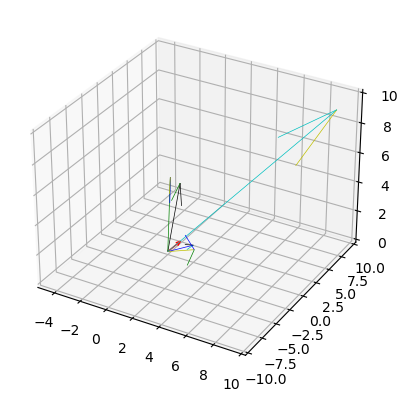

In [293]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.quiver([0]*5,[0]*5,[0]*5, candidates[:, 0], candidates[:,1], candidates[:,2], color=['black','g','b','y','c'], linewidths=0.5)
ax.quiver(0,0,0,v[0],v[1],v[2],color='r', linewidths=1)

ax.set_xlim([-5, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([0, 10])

plt.show()

### Test your translation and compute its accuracy

**Exercise**:
Complete the function `test_vocabulary` which takes in English
embedding matrix $X$, French embedding matrix $Y$ and the $R$
matrix and returns the accuracy of translations from $X$ to $Y$ by $R$.

* Iterate over transformed English word embeddings and check if the
closest French word vector belongs to French word that is the actual
translation.
* Obtain an index of the closest French embedding by using
`nearest_neighbor` (with argument `k=1`), and compare it to the index
of the English embedding you have just transformed.
* Keep track of the number of times you get the correct translation.
* Calculate accuracy as $$\text{accuracy}=\frac{\#(\text{correct predictions})}{\#(\text{total predictions})}$$

In [ ]:
# UNQ_C10 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_vocabulary(X, Y, R):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    pred = np.matmul(X, R)
    count = 0
    
    for i in range(len(pred)):
        if nearest_neighbor(pred[i], Y) == i:
            count += 1
    
    return round(count/Y.shape[0], 3)

In [494]:
# UNQ_C10 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_vocabulary(X, Y, R):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''
    pred = np.dot(X, R)
    count = 0
    
    for i in range(len(pred)):
        if nearest_neighbor(pred[i], Y)[0] == i:
            count += 1
    
    return round(count/Y.shape[0], 3)

Let's see how is your translation mechanism working on the unseen data:

In [530]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [531]:
len(en_fr_test), X_val.shape, Y_val.shape

(1500, (1500, 300), (1500, 300))

In [532]:
%%time

acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.726
CPU times: total: 56.9 s
Wall time: 56.8 s


**Expected Output**:

```
0.557
```

You managed to translate words from one language to another language
without ever seing them with almost 56% accuracy by using some basic
linear algebra and learning a mapping of words from one language to another!

# 3. LSH and document search

In this part of the assignment, you will implement a more efficient version
of k-nearest neighbors using locality sensitive hashing.
You will then apply this to document search.

* Process the tweets and represent each tweet as a vector (represent a
document with a vector embedding).
* Use locality sensitive hashing and k nearest neighbors to find tweets
that are similar to a given tweet.

In [356]:
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

### 3.2 Getting the document embeddings

#### Bag-of-words (BOW) document models
Text documents are sequences of words.
* The ordering of words makes a difference. For example, sentences "Apple pie is
better than pepperoni pizza." and "Pepperoni pizza is better than apple pie"
have opposite meanings due to the word ordering.
* However, for some applications, ignoring the order of words can allow
us to train an efficient and still effective model.
* This approach is called Bag-of-words document model.

#### Document embeddings
* Document embedding is created by summing up the embeddings of all words
in the document.
* If we don't know the embedding of some word, we can ignore that word.

**Exercise**:
Complete the `get_document_embedding()` function.
* The function `get_document_embedding()` encodes entire document as a "document" embedding.
* It takes in a docoument (as a string) and a dictionary, `en_embeddings`
* It processes the document, and looks up the corresponding embedding of each word.
* It then sums them up and returns the sum of all word vectors of that processed tweet.

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> You can handle missing words easier by using the `get()` method of the python dictionary instead of the bracket notation (i.e. "[ ]"). See more about it <a href="https://stackoverflow.com/a/11041421/12816433" >here</a> </li>
    <li> The default value for missing word should be the zero vector. Numpy will <a href="https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html" > broadcast </a> simple 0 scalar into a vector of zeros during the summation.</li>
    <li>Alternatively, skip the addition if a word is not in the dictonary. </li>
    <li>  You can use your `process_tweet()` function which allows you to process the tweet. The function just takes in a tweet and returns a list of words.</li>
</ul>
</p>

In [344]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [345]:
def get_document_embedding(tweet, en_embeddings): 
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - tweet_embedding: a
    '''
    return sum([en_embeddings[word] for word in process_tweet(tweet) if word in en_embeddings])

In [534]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([-0.0398099 , -0.20691411,  0.0616893 ,  0.1492367 ,  0.12188119],
      dtype=float32)

#### Store all document vectors into a dictionary
Now, let's store all the tweet embeddings into a dictionary.
Implement `get_document_vecs()`

In [610]:
# UNQ_C14 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_document_vecs(all_docs, en_embeddings):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - doc_vecs: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''

    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    doc_vecs = [get_document_embedding(doc, en_embeddings) for doc in all_docs]
    
    if int in [type(doc) for doc in doc_vecs]:
        for doc in doc_vecs:
            if type(doc) is not int:
                doc_len = len(doc)
                break
        
        for i,doc in enumerate(doc_vecs):
            if type(doc) == int:
                doc_vecs[i] = np.ones(len(doc_vecs[0]))*doc
    
    doc_vecs = np.array(doc_vecs)
    
    return doc_vecs, {i: doc_vec for i,doc_vec in enumerate(doc_vecs)}

In [611]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)

- `((pd.DataFrame(ind2Tweet) == 0).sum()).value_counts()`

    - 0:      8653
    - 300:    1347
    - dtype: int64

- `ind2Tweet[3]`
    - 0

In [615]:
[ind2Tweet[tw][:5] for tw in [0,1]]

[array([ 0.0309365 , -0.18327793, -0.0265343 , -0.01930636,  0.08715737]),
 array([-0.06805824, -0.05019429, -0.07516   ,  0.10280149, -0.12424301])]

In [612]:
document_vecs

array([[ 0.0309365 , -0.18327793, -0.0265343 , ..., -0.0510788 ,
         0.1917097 ,  0.0342931 ],
       [-0.06805824, -0.05019429, -0.07516   , ...,  0.19351122,
         0.40420151,  0.06717461],
       [-0.16645733, -0.04558986, -0.09931946, ...,  0.14182466,
         0.15270641,  0.15162799],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0874929 , -0.09656841, -0.18369341, ..., -0.13919711,
        -0.0238108 , -0.05184384],
       [-0.1526522 , -0.107896  , -0.09015776, ...,  0.0303527 ,
         0.1685475 ,  0.0490873 ]])

In [616]:
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


##### Expected Output
```
length of dictionary 10000
shape of document_vecs (10000, 300)
```

## 3.3 Looking up the tweets.

Now you have a vector of dimension (m,d) where `m` is the number of tweets
(10,000) and `d` is the dimension of the embeddings (300).  Now you
will input a tweet, and use cosine similarity to see which tweet in our
corpus is similar to your tweet.

In [617]:
my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [618]:
# this gives you a similar tweet as your input.
# this implementation is vectorized...
idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

@zoeeylim sad sad sad kid :( it's ok I help you watch the match HAHAHAHAHA


##### Expected Output

```
@zoeeylim sad sad sad kid :( it's ok I help you watch the match HAHAHAHAHA
```

## 3.4 Finding the most similar tweets with LSH

You will now implement locality sensitive hashing (LSH) to identify the most similar tweet.
* Instead of looking at all 10,000 vectors, you can just search a subset to find
its nearest neighbors.

Let's say your data points are plotted like this:


<div style="width:image width px; font-size:100%; text-align:center;"><img src='one.png' alt="alternate text" width="width" height="height" style="width:400px;height:200px;" /> Figure 3 </div>

You can divide the vector space into regions and search within one region for nearest neighbors of a given vector.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='four.png' alt="alternate text" width="width" height="height" style="width:400px;height:200px;" /> Figure 4 </div>

In [619]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 10000 and each has 300 dimensions.


#### Choosing the number of planes

* Each plane divides the space to $2$ parts.
* So $n$ planes divide the space into $2^{n}$ hash buckets.
* We want to organize 10,000 document vectors into buckets so that every bucket has about $~16$ vectors.
* For that we need $\frac{10000}{16}=625$ buckets.
* We're interested in $n$, number of planes, so that $2^{n}= 625$. Now, we can calculate $n=\log_{2}625 = 9.29 \approx 10$.

In [620]:
# The number of planes. We use log2(256) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

## 3.5 Getting the hash number for a vector

For each vector, we need to get a unique number associated to that vector in order to assign it to a "hash bucket".

### Hyperlanes in vector spaces
* In $3$-dimensional vector space, the hyperplane is a regular plane. In $2$ dimensional vector space, the hyperplane is a line.
* Generally, the hyperplane is subspace which has dimension $1$ lower than the original vector space has.
* A hyperplane is uniquely defined by its normal vector.
* Normal vector $n$ of the plane $\pi$ is the vector to which all vectors in the plane $\pi$ are orthogonal (perpendicular in $3$ dimensional case).

### Using Hyperplanes to split the vector space
We can use a hyperplane to split the vector space into $2$ parts.
* All vectors whose dot product with a plane's normal vector is positive are on one side of the plane.
* All vectors whose dot product with the plane's normal vector is negative are on the other side of the plane.

### Encoding hash buckets
* For a vector, we can take its dot product with all the planes, then encode this information to assign the vector to a single hash bucket.
* When the vector is pointing to the opposite side of the hyperplane than normal, encode it by 0.
* Otherwise, if the vector is on the same side as the normal vector, encode it by 1.
* If you calculate the dot product with each plane in the same order for every vector, you've encoded each vector's unique hash ID as a binary number, like [0, 1, 1, ... 0].

### Implementing hash buckets

We've initialized hash table `hashes` for you. It is list of `N_UNIVERSES` matrices, each describes its own hash table. Each matrix has `N_DIMS` rows and `N_PLANES` columns. Every column of that matrix is a `N_DIMS`-dimensional normal vector for each of `N_PLANES` hyperplanes which are used for creating buckets of the particular hash table.

*Exercise*: Your task is to complete the function `hash_value_of_vector` which places vector `v` in the correct hash bucket.

* First multiply your vector `v`, with a corresponding plane. This will give you a vector of dimension $(1,\text{N_planes})$.
* You will then convert every element in that vector to 0 or 1.
* You create a hash vector by doing the following: if the element is negative, it becomes a 0, otherwise you change it to a 1.
* You then compute the unique number for the vector by iterating over `N_PLANES`
* Then you multiply $2^i$ times the corresponding bit (0 or 1).
* You will then store that sum in the variable `hash_value`.

**Intructions:** Create a hash for the vector in the function below.
Use this formula:

$$ hash = \sum_{i=0}^{N-1} \left( 2^{i} \times h_{i} \right) $$

#### Create the sets of planes
* Create multiple (25) sets of planes (the planes that divide up the region).
* You can think of these as 25 separate ways of dividing up the vector space with a different set of planes.
* Each element of this list contains a matrix with 300 rows (the word vector have 300 dimensions), and 10 columns (there are 10 planes in each "universe").

In [621]:
np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> numpy.squeeze() removes unused dimensions from an array; for instance, it converts a (10,1) 2D array into a (10,) 1D array</li>
</ul>
</p>

In [692]:
# UNQ_C17 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    res = sum([x * 2**i for i,x in enumerate([1 if x>0 else 0 for x in np.dot(v, planes).T])])
    return res

In [681]:
vec.shape, planes.shape

((1, 300), (300, 10))

In [693]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f"The hash value for this vector, and the set of planes at index {idx},", 
      f"is {hash_value_of_vector(vec, planes)}")

The hash value for this vector, and the set of planes at index 0, is 768


##### Expected Output

```
The hash value for this vector, and the set of planes at index 0, is 768
```

## 3.5 Creating a hash table

Given that you have a unique number for each vector (or tweet), You now want to create a hash table. You need a hash table, so that given a hash_id, you can quickly look up the corresponding vectors. This allows you to reduce your search by a significant amount of time.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='table.png' alt="alternate text" width="width" height="height" style="width:500px;height:200px;" />  </div>

Create a `make_hash_table` function, which maps the tweet vectors to a bucket and stores the vector there. It returns the `hash_table` and the `id_table`. The `id_table` allows you know which vector in a certain bucket corresponds to what tweet.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> a dictionary comprehension, similar to a list comprehension, looks like this: `{i:0 for i in range(10)}`, where the key is 'i' and the value is zero for all key-value pairs. </li>
</ul>
</p>

In [662]:
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    # number of planes is the number of columns in the planes matrix
    hash_table = {}
    id_table = {}
    
    for i,v in enumerate(vecs):
        hval = hash_value_of_vector(v, planes)
        
        if hval in id_table:
            hash_table[hval].append(v)
            id_table[hval].append(i)
        else:
            hash_table[hval] = [v]
            id_table[hval] = [i]
    
    return hash_table, id_table

In [694]:
document_vecs.shape, planes.shape

((10000, 300), (300, 10))

In [742]:
[x for x in tuple(tmp_id_table.items()) if 3<len(x[1])<7]

[(44, [65, 2347, 5546, 5871, 6962]),
 (683, [126, 522, 2149, 9264]),
 (725, [258, 3337, 3502, 3503, 6368, 9660]),
 (500, [265, 3962, 4032, 6911]),
 (559, [293, 1347, 1688, 3401, 7392]),
 (941, [426, 2756, 5869, 6192, 7998]),
 (414, [460, 1321, 5001, 5083, 5616, 7773]),
 (245, [509, 856, 1146, 4017, 4440]),
 (938, [523, 1341, 6036, 8418, 9343]),
 (831, [568, 3432, 5687, 6837, 7014]),
 (88, [595, 1704, 2391, 2539, 4193, 9602]),
 (57, [599, 2209, 4255, 4688, 4713]),
 (387, [687, 1580, 4272, 4800]),
 (406, [760, 3878, 4487, 9024]),
 (952, [764, 1038, 3249, 3483, 5023]),
 (687, [774, 2479, 5879, 8439, 8902, 9784]),
 (182, [808, 4089, 5472, 6326, 6622, 9566]),
 (659, [815, 1924, 2542, 5729, 8723]),
 (272, [836, 2118, 3114, 8797, 9039]),
 (818, [867, 1491, 2288, 4126, 4857, 6789]),
 (291, [874, 4390, 5415, 5651, 9375]),
 (153, [916, 1418, 3492, 7035]),
 (165, [941, 6122, 7041, 7197]),
 (483, [945, 2921, 3322, 3594, 5859]),
 (1014, [1129, 1978, 4027, 4825, 8120]),
 (655, [1148, 5479, 8772, 976

In [743]:
planes = planes_l[0]  # get one 'universe' of planes to test the function
print(planes.shape,'')

tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)

(300, 10) 


In [749]:
hval = 56
print(f"The hash table at key {hval} has {len(tmp_hash_table[hval])} document vectors")
print(f"The id table at key {hval} has {len(tmp_id_table[hval])} indices")
print(f"The first 5 document indices stored at key {hval} of id_table are {tmp_id_table[hval][0:5]}")
print("The corresponding embeddings (first 4 values) are:")
[vec[:4] for vec in tmp_hash_table[hval][:5]]

The hash table at key 56 has 6 document vectors
The id table at key 56 has 6 indices
The first 5 document indices stored at key 56 of id_table are [2649, 6239, 6624, 6977, 7273]
The corresponding embeddings (first 4 values) are:


[array([ 0.0290266,  0.0256658, -0.0138416, -0.0174541]),
 array([ 0.0290266,  0.0256658, -0.0138416, -0.0174541]),
 array([ 0.0290266,  0.0256658, -0.0138416, -0.0174541]),
 array([ 0.0290266,  0.0256658, -0.0138416, -0.0174541]),
 array([ 0.0290266,  0.0256658, -0.0138416, -0.0174541])]

### 3.6 Creating all hash tables

You can now hash your vectors and store them in a hash table that
would allow you to quickly look up and search for similar vectors.
Run the cell below to create the hashes. By doing so, you end up having
several tables which have all the vectors. Given a vector, you then
identify the buckets in all the tables.  You can then iterate over the
buckets and consider much fewer vectors. The more buckets you use, the
more accurate your lookup will be, but also the longer it will take.

In [754]:
# Creating the hashtables
hash_table = []
id_table = []
for planes in planes_l:
    hash_val, id_val = make_hash_table(document_vecs, planes)
    hash_table.append(hash_val)
    id_table.append(id_val)

# there are 25 hashes
len(hash_table)

25

In [763]:
[(x[0], x[1], y[1]) for x in tuple(id_table[0].items()) for y in tuple(id_table[1].items()) 
 if ((x[0]==y[0]) & (3<len(x[1])<7) & (3<len(y[1])<7))]

[(414, [460, 1321, 5001, 5083, 5616, 7773], [4003, 5452, 6244, 7008, 7467]),
 (153, [916, 1418, 3492, 7035], [3962, 6641, 6901, 7263, 7862, 8077]),
 (483, [945, 2921, 3322, 3594, 5859], [115, 2288, 2650, 8645]),
 (225, [1789, 4727, 7686, 8818], [2322, 3051, 4281, 7073, 8373, 9632]),
 (1003, [1894, 2793, 2993, 7103, 7771], [1879, 2145, 6875, 8845, 9863]),
 (81, [1925, 3418, 4064, 6208, 8995], [2177, 4461, 4734, 6327, 8855]),
 (457, [2300, 3175, 5759, 8377], [3496, 6045, 7910, 9247]),
 (779, [2889, 5902, 7043, 8724], [355, 4761, 7755, 8439, 8563]),
 (371, [3117, 4803, 5414, 5973, 6898], [3772, 5652, 5800, 9233, 9678])]

### Approximate K-NN

Implement approximate K nearest neighbors using locality sensitive hashing,
to search for documents that are similar to a given document at the
index `doc_id`.

##### Inputs
* `doc_id` is the index into the document list `all_tweets`.
* `v` is the document vector for the tweet in `all_tweets` at index `doc_id`.
* `planes_l` is the list of planes (the global variable created earlier).
* `k` is the number of nearest neighbors to search for.
* `num_universes_to_use`: to save time, we can use fewer than the total
number of available universes.  By default, it's set to `N_UNIVERSES`,
which is $25$ for this assignment.

The `approximate_knn` function finds a subset of candidate vectors that
are in the same "hash bucket" as the input vector 'v'.  Then it performs
the usual k-nearest neighbors search on this subset (instead of searching
through all 10,000 tweets).

<details>
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> There are many dictionaries used in this function.  Try to print out planes_l, hash_tables, id_tables to understand how they are structured, what the keys represent, and what the values contain.</li>
    <li> To remove an item from a list, use `.remove()` </li>
    <li> To append to a list, use `.append()` </li>
    <li> To add to a set, use `.add()` </li>
</ul>
</p>

In [811]:
from statistics import mode

In [850]:
# Function to do the fast nearest neighbor search. 
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=N_UNIVERSES):
    """Search for k-NN using hashes."""
    k += 1
    
    hvals = [hash_value_of_vector(v, planes_l[i]) for i in range(num_universes_to_use)]
    
    id_list = [id_table[i][hv] for i,hv in enumerate(hvals)]
    
    vec_list = [hash_table[i][hv] for i,hv in enumerate(hvals)]
    
    id_indices_list = [nearest_neighbor(v, candidates, k) for candidates in vec_list]
    
    universe_indices_list = [np.array(id_list[i])[[list(indices)]] for i,indices in enumerate(id_indices_list)]
    
    doc_indices = [x[0,i] for x in universe_indices_list for i in range(k)]
    
    top_k = []
    for i in range(k):
        index = mode(doc_indices)
        top_k.append(index)
        doc_indices.remove     
        while index in doc_indices:
            doc_indices.remove(index)
    
    top_k.remove(top_k[0])
    
    print(f'Removed doc_id {doc_id} of input vector from new_ids_to_search')
    print(f'{k-1} Nearest Doc ids: {top_k}')
    
    return top_k

In [766]:
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

In [851]:
nearest_neighbor_ids = approximate_knn(doc_id, vec_to_search, planes_l, k=3, num_universes_to_use=5)

Removed doc_id 0 of input vector from new_ids_to_search
3 Nearest Doc ids: [51, 105, 2478]


In [845]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")

Nearest neighbors for document 0
Document contents: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Nearest neighbor at document id 51
document contents: #FollowFriday @France_Espana @reglisse_menthe @CCI_inter for being top engaged members in my community this week :)
Nearest neighbor at document id 105
document contents: #FollowFriday @straz_das @DCarsonCPA @GH813600 for being top engaged members in my community this week :)
Nearest neighbor at document id 2478
document contents: #ShareTheLove @oymgroup @musicartisthere for being top HighValue members this week :) @nataliavas http://t.co/IWSDMtcayt


# 4 Conclusion
Congratulations - Now you can look up vectors that are similar to the
encoding of your tweet using LSH!